## **PYTHON CODE TO COMPUTE NDVI FOR BANGALORE MUNICIPALITY WARDS (BBMP) USING SENTINEL-2 IMAGERY:**

This is my first full-fledged attempt on Python coding. The core concepts were picked up after attending the course: *'Python Foundation for Spatial Analysis'*, conducted by <a href="https://spatialthoughts.com/" target="_blank">Ujaval Gandhi</a>. Thank you Ujaval for all the guidance during the course!  

## What is NDVI?
Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs).

#### *Formula:*  **ndvi = (nir - red) / (nir + red)**
where,
* nir = near-infrared
* red = red light

The result of this formula generates a value between -1 and +1. If you have low reflectance (or low values) in the red channel and high reflectance in the NIR channel, this will yield a high NDVI value. And vice versa.

Overall, NDVI is a standardized way to measure healthy vegetation. When you have high NDVI values, you have healthier vegetation. When you have low NDVI, you have less or no vegetation.

<a href="https://gisgeography.com/ndvi-normalized-difference-vegetation-index/" target="_blank">Refer here for further details.</a>


### About this Code:
The current study area of Bangalore Municipality (BBMP) has a total of 198 municipal wards. After generating the NDVI imagery for the Bangalore region using the Sentinel-2 imagery, a Zonal statistics computation is done in reference to the municipal ward map of BBMP so that an average value of NDVI can be associated for the area covered by each of the municipal ward. 

This average value of NDVI, is a generalized index of vegetation for a ward. It is then compared with the average values in different wards to generate a ranking of the wards: 
* The ward scoring the highest average value of NDVI is Ranked as 1st, which means the area under this ward has the highest representation of healthy vegetation. 
* The ward scoring the lowest average value of NDVI is Ranked as 198, which means the area under this ward has the lowest representation of healthy vegetation.

The results are tabulated and attributed to the ward map so that it can be visualized in a GIS software.


The following are the Objectives of this python code:
1. Generate the NDVI imagery from input Sentinel-2 satellite image.
2. Clip the NDVI imagery to the extents of BBMP boundary.
3. Compute the Zonal Statistics on NDVI imagery and assign the *'mean'* value of NDVI to corresponding wards of BBMP.
4. Rank the wards in the descending value of NDVI, such that highest value NDVI is Ranked '1' and lowest value is Ranked '198'.
5. Add the NDVI value and Rank of wards as attributes to the BBMP ward map and generate a new map in ESRI *.shp* file format.


*Note: At key stages of the coade, a plot is generated alongside the code to depict the evolution of output.*

### Data Source:
* Bangalore Sentinel-2 Imagery. Downloaded from <a href="https://scihub.copernicus.eu/" target="_blank">Copernicus Open Access Hub.</a> Copyright European Space Agency - ESA.
* Bangalore Ward Maps Provided by <a href="http://projects.datameet.org/Municipal_Spatial_Data/" target="_blank">Spatial Data of Municipalities (Maps)</a> Project by Data{Meet}. 

In [1]:
# Import all required modules to execute the program...

import os
import glob
import fiona
import rasterio
import rasterstats
import rasterio.mask
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterio.plot import show
import matplotlib.pyplot as plt

# Define the input data path...
data_pkg_path = 'PROJECT\input'
sentinel2_dir = 'sentinel2'
pattern = '*.jp2'

path = os.path.join(data_pkg_path, sentinel2_dir, pattern)

files = glob.glob(path)
      
bands = {
    'red': 'B04',
    'green': 'B03',
    'blue': 'B02',
    'nir': 'B08'
}
band_files = {}

for band_name, band_number in bands.items():
    for filename in files:
        if band_number in filename:
            band_files[band_name] = filename

red_dataset = rasterio.open(band_files['red'])
metadata = red_dataset.meta

band_datasets = {}
for band_name, band_file in band_files.items():
    dataset = rasterio.open(band_file)
    band_dataset = dataset.read(1)
    band_datasets[band_name] = band_dataset
    dataset.close()

red = band_datasets['red'].astype(np.float32)
nir = band_datasets['nir'].astype(np.float32)

np.seterr(divide='ignore', invalid='ignore')

# NDVI computation...
ndvi = (nir - red) / (nir + red)

metadata.update({'count': 1, 'dtype': 'float32', 'driver': 'GTiff'})

output_filename = 'ndvisenblr.tif' # alternatively prompt the user to input file name with this code: input ('enter file name with a .tif extension: ')
output_dir = 'PROJECT\output'
output_path = os.path.join(output_dir, output_filename)

ndvi_dataset = rasterio.open(output_path, 'w', **metadata)
ndvi_dataset.write(ndvi, 1)
ndvi_dataset.close()
print('\n Successfully written NDVI computed output file at {}'.format(output_path))



 Successfully written NDVI computed output file at PROJECT\output\ndvisenblr.tif


In [2]:
# Assing the paths of input and output files...
shp_path = 'PROJECT\input\BBMP_boundary.shp'
inp_ras = output_path
clp_file = 'ndvisenblr_bbmp.tif' # alternatively prompt user to name file by this code: input('enter output file name with a .tif extension to save clipped image: ')
clp_dir = 'PROJECT\output'
clp_path = os.path.join(clp_dir, clp_file)
print('\n All set, proceed to the next section')


 All set, proceed to the next section


(699960.0, 809760.0, 1390200.0, 1500000.0)

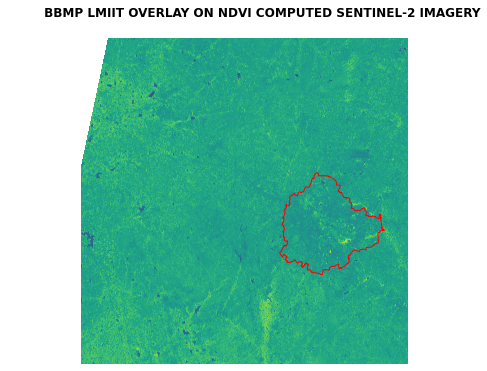

In [3]:
# Display the overal of BBMP boundary on NDVI computed Sentinel imagery...
aoi = gpd.read_file(shp_path)

fig, ax = plt.subplots(1, figsize=(10,6))
aoi.plot(facecolor = 'None', edgecolor = 'Red', ax=ax)
raster = rasterio.open(inp_ras, "r")
show(raster,ax=ax, title = '         BBMP LMIIT OVERLAY ON NDVI COMPUTED SENTINEL-2 IMAGERY\n')
ax.axis('off')

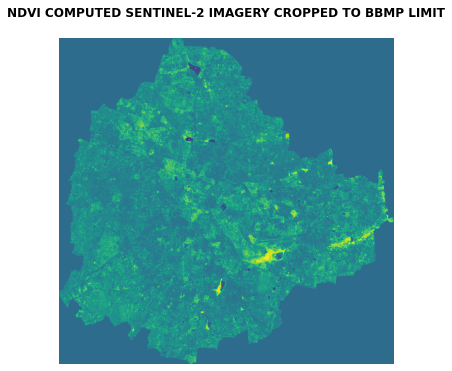

In [4]:
# Clip the raster with the polygon and write the clipped data into output...

with fiona.open(shp_path) as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(inp_ras) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "nodata": 0.0,
                 "transform": out_transform})

with rasterio.open(clp_path, "w", **out_meta) as dest:
    dest.write(out_image)
    fig, ax = plt.subplots(1, figsize=(10,6))
    aoi.plot(facecolor = 'None', edgecolor = 'Red', ax=ax)
    ax.axis('off')
    show(out_image, ax=ax, title = "NDVI COMPUTED SENTINEL-2 IMAGERY CROPPED TO BBMP LIMIT\n")
    ax.axis('off')   

In [5]:
# Assign the paths of input and output files to generate the wardwise computation...
wards_shp = 'PROJECT\input\BBMP_WARDS.shp'
ndvi_ras = clp_path

print('All set, you can proceed to next section')

All set, you can proceed to next section


(766950.0, 802060.0, 1420180.0, 1454460.0)

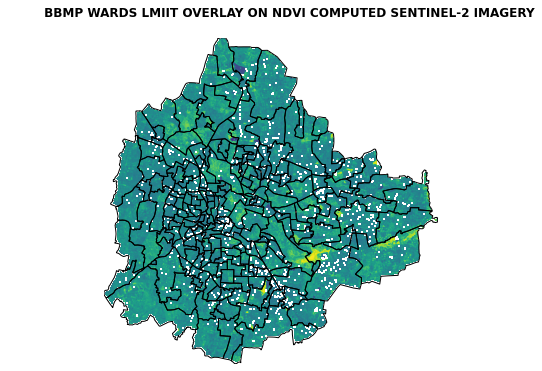

In [6]:
# Display the overlay of BBMP ward map on the cropped NDVI imagery of BLR...
bbmp_aoi = gpd.read_file(wards_shp)
raster = rasterio.open(ndvi_ras, "r")
fig, ax = plt.subplots(1, figsize=(10,6))
bbmp_aoi.plot(facecolor = 'none', edgecolor = 'black', ax=ax)
ax.axis('off')
show(raster, ax=ax, title = '         BBMP WARDS LMIIT OVERLAY ON NDVI COMPUTED SENTINEL-2 IMAGERY\n')
ax.axis('off')

In [7]:
# Assign raster values to a numpy nd array to enable Zonal Statistics computation...

raster_array = raster.read(1)
affine = raster.transform
print(raster_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
# Calculate the zonal statistics of NDVI (mean value) for each ward of BBMP...

avg_raster = rasterstats.zonal_stats(bbmp_aoi, raster_array, affine = affine, nodata = 0.0,
                                       stats = ['mean'],  
                                       geojson_out = True)
print('Zonal Stats has been computed and the NDVI mean value is deduced for each ward')

Zonal Stats has been computed and the NDVI mean value is deduced for each ward


In [10]:
# checkout the length of the numpy array and a specific record to be sure of the coding...

print('Total count of wards in BBMP is:',len(avg_raster))                      # corresponds to the total count of wards in BBMP
print('Zonal Stats for a typical ward is:\n',avg_raster[100]['properties'])        # Displays record for a typical ward

Total count of wards in BBMP is: 198
Zonal Stats for a typical ward is:
 {'DISPLAY_NA': 'Bangalore City Junction Railway, M.G. Railway Colony, Sevashrama, Bengaluru', 'MOVEMENT_I': '101', 'WARD_NAME': 'Subhash Nagar', 'WARD_NO': '95', 'mean': 0.14990860880938753}


In [11]:
# Extract the properties including the zonal statistics, of each ward of the BBMP and assign into a list...

average_ndvi = []
i = 0

while i < len(avg_raster):
    average_ndvi.append(avg_raster[i]['properties'])
    i = i+1

print('All done, proceed to next section')

All done, proceed to next section


In [12]:
# Transferring the information from the list to a pandas DataFrame and visualize the same...

avg_ndvi_bbmp = pd.DataFrame(average_ndvi)
avg_ndvi_bbmp.head()

,DISPLAY_NA,MOVEMENT_I,WARD_NAME,WARD_NO,mean
0,"Unnamed Road, Bengaluru",1,Chowdeswari Ward,2,0.247684
1,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...",2,Atturu,3,0.218791
2,"15th A Cross Road, Yelahanka Satellite Town, Y...",3,Yelahanka Satellite Town,4,0.223052
3,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...",4,Vijnanapura,51,0.142986
4,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...",5,Basavanapura,53,0.159815


In [13]:
# Read the attribute table of BBMP wards shape file...

wards_gdf = gpd.read_file(wards_shp)
print(wards_gdf.info())
wards_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   WARD_NO     198 non-null    object  
 1   WARD_NAME   198 non-null    object  
 2   MOVEMENT_I  198 non-null    object  
 3   DISPLAY_NA  198 non-null    object  
 4   geometry    198 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 7.9+ KB
None


,WARD_NO,WARD_NAME,MOVEMENT_I,DISPLAY_NA,geometry
0,2,Chowdeswari Ward,1,"Unnamed Road, Bengaluru","POLYGON ((781088.725 1449325.974, 780940.947 1..."
1,3,Atturu,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...","POLYGON ((778486.548 1452604.133, 778705.911 1..."
2,4,Yelahanka Satellite Town,3,"15th A Cross Road, Yelahanka Satellite Town, Y...","POLYGON ((780940.947 1449460.144, 781088.725 1..."
3,51,Vijnanapura,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...","POLYGON ((790361.060 1439931.721, 790374.834 1..."
4,53,Basavanapura,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...","POLYGON ((796012.536 1441003.561, 796115.599 1..."


In [14]:
# Join the Zonal statistics of each ward w.r.t the attribute table of the BBMP wards map...

wards_gdf = wards_gdf.merge(avg_ndvi_bbmp, on = 'WARD_NO')
type(wards_gdf.info())
wards_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 198 entries, 0 to 197
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   WARD_NO       198 non-null    object  
 1   WARD_NAME_x   198 non-null    object  
 2   MOVEMENT_I_x  198 non-null    object  
 3   DISPLAY_NA_x  198 non-null    object  
 4   geometry      198 non-null    geometry
 5   DISPLAY_NA_y  198 non-null    object  
 6   MOVEMENT_I_y  198 non-null    object  
 7   WARD_NAME_y   198 non-null    object  
 8   mean          198 non-null    float64 
dtypes: float64(1), geometry(1), object(7)
memory usage: 15.5+ KB


,WARD_NO,WARD_NAME_x,MOVEMENT_I_x,DISPLAY_NA_x,geometry,DISPLAY_NA_y,MOVEMENT_I_y,WARD_NAME_y,mean
0,2,Chowdeswari Ward,1,"Unnamed Road, Bengaluru","POLYGON ((781088.725 1449325.974, 780940.947 1...","Unnamed Road, Bengaluru",1,Chowdeswari Ward,0.247684
1,3,Atturu,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...","POLYGON ((778486.548 1452604.133, 778705.911 1...","9th Cross Bhel Layout, Adityanagar, Vidyaranya...",2,Atturu,0.218791
2,4,Yelahanka Satellite Town,3,"15th A Cross Road, Yelahanka Satellite Town, Y...","POLYGON ((780940.947 1449460.144, 781088.725 1...","15th A Cross Road, Yelahanka Satellite Town, Y...",3,Yelahanka Satellite Town,0.223052
3,51,Vijnanapura,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...","POLYGON ((790361.060 1439931.721, 790374.834 1...","SP Naidu Layout 4th Cross Street, SP Naidu Lay...",4,Vijnanapura,0.142986
4,53,Basavanapura,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...","POLYGON ((796012.536 1441003.561, 796115.599 1...","Medahalli Kadugodi Road, Bharathi Nagar, Krish...",5,Basavanapura,0.159815


In [15]:
# Filter unwanted columns and rename retained column to generate the final table...

filtered = wards_gdf[['WARD_NO','WARD_NAME_x', 'geometry', 'mean']] 
filtered_wards = filtered.rename(columns = {'WARD_NAME_x':'WARD_NAME','mean':'NDVI_MEAN'}) 
type(filtered_wards.info())
filtered_wards.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   WARD_NO    198 non-null    object  
 1   WARD_NAME  198 non-null    object  
 2   geometry   198 non-null    geometry
 3   NDVI_MEAN  198 non-null    float64 
dtypes: float64(1), geometry(1), object(2)
memory usage: 7.7+ KB


,WARD_NO,WARD_NAME,geometry,NDVI_MEAN
0,2,Chowdeswari Ward,"POLYGON ((781088.725 1449325.974, 780940.947 1...",0.247684
1,3,Atturu,"POLYGON ((778486.548 1452604.133, 778705.911 1...",0.218791
2,4,Yelahanka Satellite Town,"POLYGON ((780940.947 1449460.144, 781088.725 1...",0.223052
3,51,Vijnanapura,"POLYGON ((790361.060 1439931.721, 790374.834 1...",0.142986
4,53,Basavanapura,"POLYGON ((796012.536 1441003.561, 796115.599 1...",0.159815


In [16]:
# Ranking the BBMP wards based on the Descending value of Mean_NDVI value...

filtered_wards['Rank'] = filtered_wards['NDVI_MEAN'].rank(ascending=False)

filtered_wards.head()

,WARD_NO,WARD_NAME,geometry,NDVI_MEAN,Rank
0,2,Chowdeswari Ward,"POLYGON ((781088.725 1449325.974, 780940.947 1...",0.247684,11.0
1,3,Atturu,"POLYGON ((778486.548 1452604.133, 778705.911 1...",0.218791,35.0
2,4,Yelahanka Satellite Town,"POLYGON ((780940.947 1449460.144, 781088.725 1...",0.223052,27.0
3,51,Vijnanapura,"POLYGON ((790361.060 1439931.721, 790374.834 1...",0.142986,135.0
4,53,Basavanapura,"POLYGON ((796012.536 1441003.561, 796115.599 1...",0.159815,108.0


In [17]:
# Write the final table as a SHAPE file into the drive (can be opened in QGIS)...

foutput_dir = 'PROJECT\output'
foutput_filename = 'BBMP_WARDWISE_NDVI_RANK.shp' # alternatively prompt the user to input file name: input('Enter output file name with a .shp extension: ') #'BBMP_WARDWISE_NDVI.shp'
foutput_path = os.path.join(foutput_dir, foutput_filename)

filtered_wards.to_file(driver='GPKG', filename=foutput_path, encoding='utf-8')
print('Successfully written output file at {}'.format(foutput_path))

Successfully written output file at PROJECT\output\BBMP_WARDWISE_NDVI_RANK.shp


In [18]:
# Summarize the Wards having Highest & Lowest Values of NDVI_MEAN...

finalmap = gpd.read_file(foutput_path)
df = pd.DataFrame(finalmap)

rowmax = df.iloc[df['NDVI_MEAN'].idxmax()]
print('\nThe Ward having highest value of NDVI:\n',
      rowmax[['WARD_NO','WARD_NAME','NDVI_MEAN','Rank']])

rowmin = df.iloc[df['NDVI_MEAN'].idxmin()]
print('\nThe Ward having lowest value of NDVI:\n',
      rowmin[['WARD_NO','WARD_NAME','NDVI_MEAN','Rank']])


The Ward having highest value of NDVI:
 WARD_NO           114
WARD_NAME      Agaram
NDVI_MEAN    0.330514
Rank                1
Name: 90, dtype: object

The Ward having lowest value of NDVI:
 WARD_NO            109
WARD_NAME    Chickpete
NDVI_MEAN    0.0601847
Rank               198
Name: 95, dtype: object


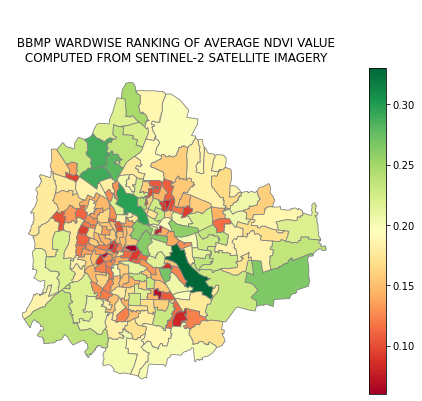

In [19]:
# PLOT THE FINAL OUTPUT MAP AS A CHOROPLETH, by calling the wardwise mean value of NDVI...

finalmap = gpd.read_file(foutput_path)
variable = 'NDVI_MEAN'
df = pd.DataFrame(finalmap)

column = df[variable]

vmax = column.max()
vmin = column.min()

fig, ax = plt.subplots(1, figsize=(10,6))

finalmap.plot(column = variable, cmap = 'RdYlGn', linewidth = 0.8, ax = ax, edgecolor='0.5')
ax.axis('off')
ax.set_title('\n\n BBMP WARDWISE RANKING OF AVERAGE NDVI VALUE''\n COMPUTED FROM SENTINEL-2 SATELLITE IMAGERY')
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)